## Import Packages

In [1]:
import rdkit
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics 

## Read files and create dataframe with Smiles

In [2]:
df_smiles1 = pd.read_csv('tested_molecules.csv')
df_smiles2 = pd.read_csv('tested_molecules_v2.csv')
df_smiles = pd.concat([df_smiles1, df_smiles2], ignore_index=True)
print(df_smiles)

                                                 SMILES  ALDH1_inhibition
0     COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...                 1
1                O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1                 1
2     Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...                 1
3                     CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1                 1
4     CS(=O)(=O)N1CCc2cc(-c3csc(NC(=O)Cc4cccs4)n3)ccc21                 1
...                                                 ...               ...
1995                    C/C(=N\NC(=S)Nc1ccc(F)cc1)C1CC1                 1
1996                     COC(=O)c1c(NC(C)=O)sc2c1CCCCC2                 1
1997                            O=C(CCl)NC1CCCc2ccccc21                 1
1998    COc1ccc(-n2c(SCC(=O)N3CCCCC3C)nnc2-c2cccnc2)cc1                 1
1999  COc1ccc(NC(=O)C2CCC(N3C(=O)C4C5C=CC(C5)C4C3=O)...                 1

[2000 rows x 2 columns]


## Check descriptor values for all Smiles

In [3]:
def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
    
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res

In [4]:
allDescrs = []
for _, row in df_smiles.iterrows():
    mol = row['SMILES']
    m = Chem.MolFromSmiles(mol)
    descriptors = getMolDescriptors(m)
    allDescrs.append(descriptors)
    
df_descr = pd.DataFrame(allDescrs)
df_descr.head()


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.083531,-0.683140,13.083531,0.001173,0.520365,463.542,434.310,463.233188,178,0,...,0,0,0,0,1,0,0,0,0,0
1,12.170097,-0.066966,12.170097,0.066966,0.498564,378.457,360.313,378.115047,136,0,...,1,0,0,0,0,0,0,0,0,0
2,10.905837,-0.016881,10.905837,0.016881,0.382043,477.589,444.325,477.260865,184,0,...,0,0,0,0,1,0,0,0,0,0
3,11.562446,-0.454447,11.562446,0.270607,0.795948,330.609,317.505,328.981818,96,0,...,0,0,0,0,0,0,0,0,0,0
4,12.108866,-3.251317,12.108866,0.086947,0.687618,419.553,402.417,419.043204,140,0,...,0,1,0,0,0,1,0,1,0,0


## Data cleaning

Delete the collumns that have only one unique value, so a column where each value is the mean, and variance is 0

In [5]:
#Deletes colums with nonsense values (only the same values)
bad_descr=[]
for i in df_descr.columns:
    if df_descr[i].nunique() == 1:
        bad_descr.append(i)
print(bad_descr)       
df_nonzero=df_descr.drop(columns=bad_descr)  

['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'EState_VSA11', 'fr_HOCCN', 'fr_azide', 'fr_benzodiazepine', 'fr_diazo', 'fr_isocyan', 'fr_isothiocyan', 'fr_phos_acid', 'fr_phos_ester', 'fr_prisulfonamd']


Remove variables so that no variables are left that have a hcorralation with another variable higher than the set threshold for corralation

In [6]:
corrThreshold = 0.90


correlation_mat = df_nonzero.corr()
upper_tri = correlation_mat.where(np.triu(np.ones(correlation_mat.shape),k=1).astype(bool)) 
to_drop = [column for column in upper_tri.columns if any(upper_tri[column].abs() > corrThreshold)] 
df_noCorr = df_nonzero.drop(columns=to_drop)



df_noCorr.head()

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.083531,-0.683140,0.001173,0.520365,463.542,0.249868,-0.496477,1.088235,16.465857,10.012387,...,0,0,0,0,1,0,0,0,0,0
1,12.170097,-0.066966,0.066966,0.498564,378.457,0.230353,-0.467476,1.111111,32.166556,10.202245,...,1,0,0,0,0,0,0,0,0,0
2,10.905837,-0.016881,0.016881,0.382043,477.589,0.219930,-0.492903,1.228571,16.492058,9.989823,...,0,0,0,0,1,0,0,0,0,0
3,11.562446,-0.454447,0.270607,0.795948,330.609,0.351723,-0.421732,1.333333,79.918731,10.173315,...,0,0,0,0,0,0,0,0,0,0
4,12.108866,-3.251317,0.086947,0.687618,419.553,0.231765,-0.301646,1.296296,32.233291,10.071048,...,0,1,0,0,0,1,0,1,0,0


## Scale data & perform PCA

In [7]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_noCorr)

pca = PCA(n_components=150)
principalComponents = pca.fit_transform(df_scaled)
principalDf = pd.DataFrame(data = principalComponents)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

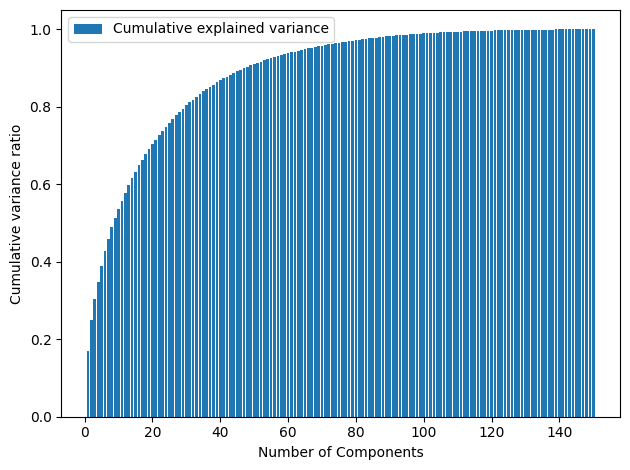

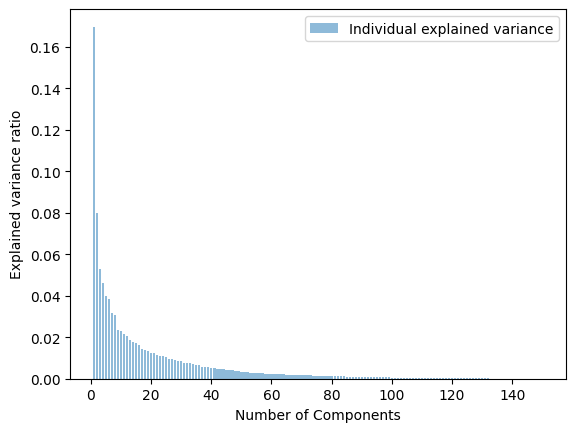

In [8]:
plt.bar(range(1,len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, align='center',label='Cumulative explained variance');
plt.ylabel('Cumulative variance ratio')
plt.xlabel('Number of Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#scree plot om aantal PCA te bepalen
plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance');
plt.ylabel('Explained variance ratio')
plt.xlabel('Number of Components')
plt.legend(loc='best')
plt.show()

In [9]:
#verwijderen van features die lage variance hebben
#x is hierbij je matrix met alle features.

selection = VarianceThreshold(threshold=(.8*(1-.8)))
df_noCorr = selection.fit_transform(df_noCorr)
selection

VarianceThreshold(threshold=0.15999999999999998)

## Split data for testing

In [10]:
features = np.array(principalDf)
feature_names = list(principalDf.columns)
target = np.array(df_smiles['ALDH1_inhibition'])

### Training & test set

In [11]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, target, test_size = 0.20, random_state = 42)

#check the shapes
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1600, 150)
Training Labels Shape: (1600,)
Testing Features Shape: (400, 150)
Testing Labels Shape: (400,)


## Predictor models

### Random Forest Regressor Model

In [12]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

Predictions

In [13]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)

predictions
#Print out the mean absolute error (mae)
#print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

array([0.467, 0.047, 0.   , 0.401, 0.114, 0.191, 0.44 , 0.621, 0.28 ,
       0.011, 0.654, 0.063, 0.01 , 0.586, 0.497, 0.473, 0.006, 0.149,
       0.012, 0.55 , 0.339, 0.179, 0.627, 0.009, 0.684, 0.488, 0.   ,
       0.451, 0.251, 0.537, 0.174, 0.415, 0.391, 0.542, 0.   , 0.278,
       0.02 , 0.001, 0.   , 0.092, 0.378, 0.476, 0.47 , 0.406, 0.033,
       0.456, 0.128, 0.394, 0.659, 0.014, 0.012, 0.411, 0.03 , 0.615,
       0.483, 0.671, 0.001, 0.412, 0.   , 0.393, 0.006, 0.45 , 0.002,
       0.009, 0.79 , 0.508, 0.438, 0.007, 0.207, 0.549, 0.077, 0.404,
       0.004, 0.   , 0.484, 0.375, 0.084, 0.503, 0.339, 0.637, 0.434,
       0.353, 0.015, 0.363, 0.024, 0.001, 0.604, 0.313, 0.514, 0.004,
       0.006, 0.707, 0.52 , 0.529, 0.566, 0.837, 0.395, 0.03 , 0.002,
       0.513, 0.54 , 0.365, 0.487, 0.001, 0.176, 0.424, 0.519, 0.169,
       0.643, 0.215, 0.358, 0.003, 0.089, 0.452, 0.322, 0.254, 0.131,
       0.459, 0.443, 0.023, 0.456, 0.187, 0.066, 0.517, 0.461, 0.   ,
       0.093, 0.587,

Test wheter the highest x predictions are accurate

In [14]:
to_be_predicted = 120 #test_labels.sum() #100 in geval van assignment

d={'predictions':predictions, 'labels':test_labels}
best_scores = pd.DataFrame(d).nlargest(to_be_predicted,columns='predictions')

accuracy = sum(best_scores['labels'])/to_be_predicted
print(accuracy)

0.6333333333333333


### Random Forest Classifier Model

In [15]:
clf=RandomForestClassifier()
clf.fit(train_features, train_labels)

RandomForestClassifier()

Predictions

In [16]:
preds = clf.predict(test_features)
print(preds)
print ("accuracy of the training set",clf.score(train_features, train_labels))
print("accuracy of the test set" ,clf.score(test_features, test_labels))

default_acc = metrics.balanced_accuracy_score(test_labels, preds)
print(default_acc)

[0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
accuracy of the training set 1.0
accuracy of the test set 0.735
0.6130952380952381


In [17]:
#determine which pc is most important, order
pd.DataFrame(clf.feature_importances_, index=principalDf.columns).sort_values(by=0, ascending=False)

,0
0,0.090074
6,0.020449
42,0.013136
27,0.012941
34,0.012387
...,...
1,0.004175
128,0.003902
73,0.003889
112,0.003700


## Support vector machine

Make SVM model without optimizing the hyperparameters

In [18]:
SVC_model_default = SVC()
SVC_model_default.fit(train_features, train_labels)
y_pred_SVC_default =SVC_model_default.predict(test_features)

Define the parameter values used in GridSearch

In [19]:
estimator_SVM = SVC(gamma = 'auto')
parameters_SVM = {
    'C':(0.1,1, 10, 100), #(0.1, 15.0, 0.1)
    'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
    'coef0': (0.0, 10.0, 1.0),
    'shrinking': (True, False)}   

Find the optimal parameter values 

In [20]:
grid_search_SVM = GridSearchCV(
    estimator=estimator_SVM,
    param_grid=parameters_SVM,
    scoring = 'balanced_accuracy',
    n_jobs = -1,
    cv = 5
)

Fit the model

In [21]:
SVM_1 = grid_search_SVM.fit(train_features, train_labels)
y_pred_SVM1 = SVM_1.predict(test_features)

Evaluate the performance

In [22]:
default_acc = metrics.balanced_accuracy_score(test_labels, y_pred_SVC_default)
optimized_acc = metrics.balanced_accuracy_score(test_labels, y_pred_SVM1)
print(default_acc)
print(optimized_acc)

0.7720238095238094
0.718452380952381


## K-nearest Neighbor

In [23]:
KN_clf=KNeighborsClassifier(n_neighbors=5)
KN_clf.fit(train_features, train_labels)

KNeighborsClassifier()

Predictions

In [24]:
KN_preds = KN_clf.predict(test_features)
print(KN_preds)
print ("accuracy of the training set",KN_clf.score(train_features, train_labels))
print("accuracy of the test set" ,KN_clf.score(test_features, test_labels))

default_acc = metrics.balanced_accuracy_score(test_labels, KN_preds)
print("Default accuracy of the test set",default_acc)

[0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0
 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0
 0 1 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0
 1 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1 1 0 1
 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0]
accuracy of the training set 0.848125
accuracy of the test set 0.7925
Default accuracy of the test set 0.7351190476190477
